# 라이브러리 로드

In [146]:
# 기본 
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt

# 딥러닝
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
# from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 가우시안 프로세스
import GPy
# from pykrige.uk import UniversalKriging

# 데이터 로드 및 확인

In [147]:
## Read PM2.5 data at June 05, 2019
df1 = pd.read_csv('C:\git\DeepKriging\covariate0605.csv')
df2 = pd.read_csv('C:\git\DeepKriging\pm25_0605.csv')

## 변수설명: meteorological variables(기상학 변수)
총 7,706개의 그리드(32x32 km)에서 측정된 자료(2019년 6월 5일) from NARR
 - `long`: 경도
 - `lat`: 위도
 - `prec`: 누적 총 강수량
 - `temp`: 기온
 - `pres`: surface pressure, 기압?
 - `rh`:  relative humidity at 2 m
 - `uwind`: u-component of wind
 - `vwind`: v-component of wind at 10 m
 

In [148]:
df1.head(5)

,Unnamed: 0,long,lat,prec,temp,pres,rh,uwind,vwind
0,41242,-69.111491,47.386418,0.283942,278.605652,96929.570312,79.589600,4.852976,1.651037
1,41243,-68.736976,47.244262,0.276129,278.605652,97242.070312,79.589600,4.470163,1.646155
2,41244,-68.364554,47.100850,0.276129,279.753113,98692.070312,75.652100,4.477976,1.624670
3,41245,-67.994227,46.956192,0.604254,280.398621,98792.070312,77.417725,4.096140,1.615881
4,41589,-69.318835,47.131182,0.174567,278.424988,96567.070312,77.456787,5.140085,1.481116


## 변수설명: $PM_{2.5}$
총 841개의 관측소에서 관측된 자료
 - PM25: 일평균(2019년 6월 5일) 미세먼지 $PM_{2.5}$관측 자료
 - PM_class: 

In [149]:
df2.head(5)

,Unnamed: 0,Longitude,Latitude,PM25,PM_class
0,1,-80.482778,25.471944,4.400000,1
1,2,-80.215556,25.794222,4.929167,1
2,3,-97.493830,25.892518,8.213636,1
3,4,-80.326389,25.941944,4.100000,1
4,5,-80.256944,26.053889,4.992754,1


In [150]:
#  기상학 자료의 위경도를 제외한 공변량만 추출
covariates = df1.values[:, 3:]
covariates.shape

(7706, 6)

In [151]:
# PM2.5 자료의 위경도만 추출
aqs_lonlat=df2.values[:,[1,2]]
aqs_lonlat.shape

(842, 2)

## 데이터 위치 시각화

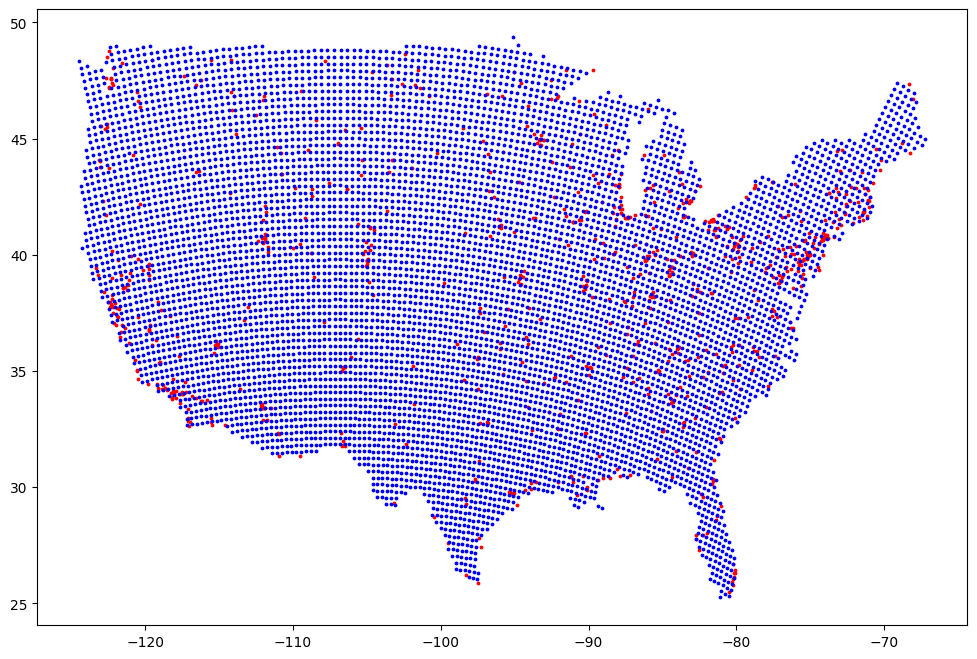

In [152]:
# PM2.5 data와 meteorogical data를 지도위에 동시에 표시

# 그림 크기 설정 (가로 12인치, 세로 8인치)
plt.figure(figsize=(12, 8))

plt.scatter(aqs_lonlat[:,0], aqs_lonlat[:,1], c='r', s=3) # PM2.5 data
plt.scatter(df1.values[:,1], df1.values[:,2], c='b', s=3) # meteorogical data
plt.show()

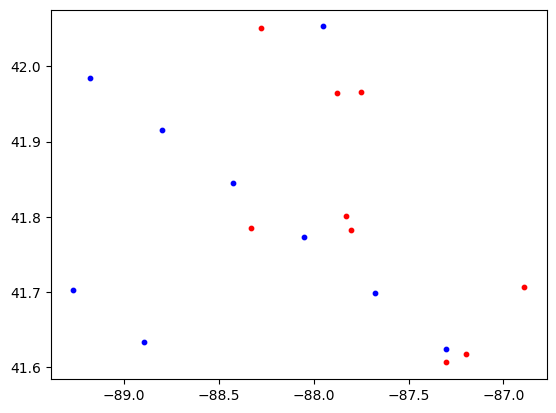

In [153]:
# "시카고"의 PM2.5 data와 meteorogical data를 지도위에 동시에 표시

## PM2.5 data에서 시카고 지역의 데이터만 추출
chicago_pm25 = df2[(df2['Latitude'] > 41.6) & (df2['Latitude'] < 42.1) & (df2['Longitude'] > -89.5) & (df2['Longitude'] < -86.5)]
chicago_pm25 = chicago_pm25.values[:,[1,2]]

## 기상학 data에서 시카고 지역의 데이터만 추출
chicago_met = df1[(df1['lat'] > 41.6) & (df1['lat'] < 42.1) & (df1['long'] > -89.5) & (df1['long'] < -86.5)]
chicago_met = chicago_met.values[:,[1,2]]

## PM2.5 data와 기상학 data를 지도위에 동시에 표시
plt.scatter(chicago_pm25[:,0], chicago_pm25[:,1], c='r', s=10) # PM2.5 data
plt.scatter(chicago_met[:,0], chicago_met[:,1], c='b', s=10) # meteorogical data
plt.show()


# 데이터 병합

## Pair the long and lat based on the nearest neighbor
 Since the coordinates from NARR and those from stations are not identical and some of stations are too close to each other, we keep the spatial resolution of NARR and average the PM25 measurements of nearby monitoring stations in the same grid cell.

 After the matching, 604 grid cells remain for the model training.

> 자료의 매칭을 하고 나면 남는 7,706-604=7,102개의 위치(기상학 자료의 해상도를 유지)에서 $PM_{2.5}$ 값의 예측이 이번 Application의 목표입니다.

자료의 매칭방법은 1-NN방법 입니다. 

In [154]:
from scipy import spatial

# 기상학 data에서 좌표정보 추출
near = df1.values[:,[1,2]] 

tree = spatial.KDTree(list(zip(near[:,0].ravel(), near[:,1].ravel())))
    # ravel() : 다차원 배열을 1차원으로 변경
    # zip() : 두개의 리스트를 하나의 튜플로 만들어줌
    ## ex) zip([1,2,3],[4,5,6]) => [(1,4),(2,5),(3,6)]
    # list() : 튜플을 리스트로 변경
    # spatial.KDTree() : KDTree 생성, 이는 다차원에서 NN을 수행해주는 함수

tree.data # KDTree의 데이터: 즉 생성된 KDTree의 좌표정보

array([[-69.11149122,  47.38641834],
       [-68.73697557,  47.24426247],
       [-68.36455383,  47.10084972],
       ...,
       [-98.12177313,  26.12568696],
       [-97.82368098,  26.09304595],
       [-97.52588153,  26.05934002]])

In [155]:
idx = tree.query(aqs_lonlat)[1] 
    # KD 트리에서 aqs_lonlat(미세먼지 관측소)과 가장 가까운 기상학 데이터를 찾습니다.
    # tree.query(aqs_lonlat)[1]은 최근접 이웃의 "인덱스"를 반환합니다.
    # tree.query(aqs_lonlat)[0]은 최근접 이웃과의 "거리"를 반환합니다.
    # 즉, 가장 가까운 기상학 데이터의 인덱스를 반환합니다.

In [156]:
# 좀 더 살펴보기
unique_indices = np.unique(tree.query(aqs_lonlat)[1])
unique_indices.shape
    # 특정 PM2.5 관측소들이 모여있어 가장 가까운 기상 데이터 좌표가 중복될 수 있습니다.
    # 밑의 그림을 통해 더 자세히 살펴볼 수 있음.

(605,)

In [157]:
# idx에서 중복이 발생한 인덱스 저장
duplicated_idx = []

for i in idx:
    if np.sum(idx == i) > 1:
        duplicated_idx.append(i)

duplicated_idx = np.array(duplicated_idx)
duplicated_idx.shape


(368,)

In [158]:
duplicated_idx

array([7549, 7549, 7512, 7512, 7512, 7512, 6798, 6798, 7503, 7503, 7459,
       7298, 7459, 7298, 6468, 6468, 7224, 7224, 7177, 7177, 5794, 5794,
       7003, 7003, 6551, 6551, 6012, 6012, 6012, 6012, 5786, 6696, 5786,
       5323, 6696, 5786, 6580, 5323, 6580, 6596, 6595, 6596, 6596, 6595,
       6595, 6595, 6485, 6485, 6363, 6363, 5429, 6139, 5429, 6139, 6252,
       6139, 6139, 6252, 6141, 6141, 6139, 5429, 6139, 6141, 6141, 6139,
       6026, 6026, 5063, 5063, 5561, 5561, 5063, 5948, 5948, 5412, 5413,
       5413, 5948, 5948, 5412, 4452, 4452, 5565, 5565, 5565, 5627, 5627,
       4568, 4067, 4568, 4442, 4442, 4442, 4442, 4067, 5460, 5459, 5459,
       5460, 5340, 5159, 5340, 5159, 5159, 4836, 4836, 4842, 4842, 3165,
       4714, 3165, 4590, 4842, 4714, 4590, 4590, 3031, 4781, 3031, 4336,
       4781, 4336, 4335, 4335, 4335, 4208, 4209, 4208, 4208, 3916, 3916,
       4209, 3789, 3660, 3660, 3660, 3660, 3149, 3149, 3789, 3660, 3276,
       3276, 3908, 3953, 3953, 3954, 3908, 3908, 39

In [159]:
# 중복이 가장 많은 기상 관측소 찾기
unique, counts = np.unique(duplicated_idx, return_counts=True)
most_freq = unique[np.argmax(counts)]
    # unique : 중복된 인덱스 값의 고유한 값들이 저장되어 있음음
    # return_counts=True : 각 고유값이 배열에서 몇 번 발생하는지 세는 주는 옵션
    # np.argmax(counts) : 중복된 횟수 중 가장 큰 값의 인덱스를 반환합니다.

In [160]:
# 중복이 가장 많은 기상 관측소의 좌표
## Recall: near은 기상학 데이터의 좌표를 저장하고 있습니다.
most_freq_x, most_freq_y= near[most_freq]
most_freq_x, most_freq_y

(-73.8973198485606, 40.6649319147812)

In [161]:
# idx에서 중복이 가장 많았던 기상소와 pm2.5 관측소의 거리중 가장 큰 값 찾기
most_pm = aqs_lonlat[idx == most_freq]
most_met = near[most_freq]

d = np.max(np.sqrt(np.sum((most_pm - most_met)**2, axis=1)))
# 반올림
d = np.round(d, 1)


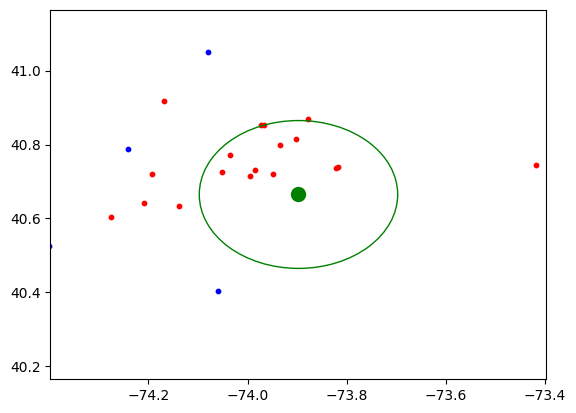

In [162]:

# 중복이 가장 많은 기상 관측소의 좌표를 찾아서 표시
plt.scatter(aqs_lonlat[:,0], aqs_lonlat[:,1], c='r', s=10) # PM2.5 data
plt.scatter(df1.values[:,1], df1.values[:,2], c='b', s=10) # meteorogical data
plt.scatter(most_freq_x, most_freq_y, c='g', s=100) # 중복이 가장 많은 기상 관측소
#  most_freq_x, most_freq_y을 중심으로 한 원 그리기
circle = plt.Circle((most_freq_x, most_freq_y), d, color='g', fill=False)
plt.gca().add_artist(circle)

plt.xlim(most_freq_x-0.5, most_freq_x+0.5)
plt.ylim(most_freq_y-0.5, most_freq_y+0.5)
plt.show()


In [163]:
df2_new = df2.assign(neighbor = idx)
    # assign() : 새로운 열을 추가
    # df2(PM data)에 neighbor 열을 추가하고, 그 값은 idx로 한다.
    # recall: idx는 PM 자료 기준으로 가장 가까운 기상학 데이터의 인덱스를 저장하고 있습니다.

df_pm25 = df2_new.groupby('neighbor')['PM25'].mean()
    # groupby() : 특정 열을 기준으로 그룹화 
    # mean() : 평균값을 구함
    # neighbor를 기준으로 PM의 평균값을 구해서 df_pm25에 저장

df_pm25_class = pd.cut(df_pm25, bins=[-0.1,12.1,35.5],labels=["0","1"])
    # cut() : 구간을 나눔
    # bins : 나눌 구간
    # labels : 구간에 대한 이름
    # PM25값을 기준으로 구간을 나누고, 0과 1로 분류함. 이를 df_pm25_class에 저장
    ## 자세히 쓰자면, -0.1~12.1은 0으로, 12.1~35.5는 1로 분류함.
    ### cut 기준을 0부터 해서 오류가 발생함. -0.1부터 시작하면 오류가 발생하지 않음.

idx_new = df_pm25.index.values
    # df_pm25의 인덱스를 idx_new에 저장
    # 병합후 남은 기상학 관측소의 인덱스를 저장
    # 이제 해당 기상학 관측소의 좌표를 사용하여 모형을 학습 시킬 것임.

위의 데이터 병합 과정을 설명해 보겠습니다. 다음과 같이 $i^{th}$ 기상학 관측소와 $i_{1}, \ldots, i_{k}$ 개의 PM 관측소가 가장 가까운 그룹으로 묶여있다고 가정하겠습니다. 여기서 $a_1, \ldots, a_k$를 각 PM 관측소에서 관측된 $PM_{2.5}$ 값이라고 하겠습니다.

$$
\begin{pmatrix}
i 기상학 자료 & i_1 PM 관측소 & a_1\\
 & i_2 PM 관측소 & a_2 \\
 & \vdots  & \\
 & i_k PM 관측소 & a_k
\end{pmatrix}
$$

$$
\rightarrow
$$

$$
\begin{pmatrix}
 & 미세먼지 농도 \\
i 기상학 자료 & (a_1 + \ldots + a_k)/k
\end{pmatrix}
$$



추가로 위의 셀에서 df_pm_class 변수를 생성한 이유는 risk of high pollution $\mathbb{P}(PM_{2.5} > 12 \, \mu g / m^3)$을 예측하기 위함입니다... 추후 사용될 예정

In [164]:
idx_new.shape

(605,)

In [165]:
# 학습에 사용될 PM2.5 데이터와 PM2.5 클래스 데이터를 각각 z와 z_class에 저장
pm25 = df_pm25.values
pm25_class = np.array(df_pm25_class.values, dtype=int)
z = pm25[:,None]
z_class = pm25_class[:,None]

In [166]:
# basis function을 구축하기 위해 좌표를 정규화
lon = df1.values[:,1]
lat = df1.values[:,2]
normalized_lon = (lon-min(lon))/(max(lon)-min(lon))
normalized_lat = (lat-min(lat))/(max(lat)-min(lat))

# 데이터의 개수를 저장합니다.
N = lon.shape[0]

In [167]:
N

7706

# Basis 함수 설정

## Wendland basis function

Let $\{\mathbf{u}_j\}, j=1,2, \ldots, m$ be a  rectangular grid of points (or node points in the radial basis function terminology).

$$
\phi\left(\left\|\mathbf{s}-\mathbf{u}_j\right\| / \theta\right) = \phi(d) =
\begin{cases}
    (1-d)^6\left(35 d^2+18 d+3\right) / 3, & d \in[0,1] \\ 0, & \text { otherwise. }
\end{cases}
$$

where the scale parameter $\theta$ is set to be 2.5 times the associated knots spacing
 according to Nychka et al. (2015).

In [168]:
# Set the number of basis functions
num_basis = [10**2,19**2,37**2] # 2차원 basis라서 제곱

# Set the knots for the basis functions: 3 sets of knots for 3 different resolutions
knots_1dx = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]
knots_1dy = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]


# Wendland kernel
basis_size = 0
phi = np.zeros((N, sum(num_basis))) # N x sum(num_basis) 크기의 0 행렬 생성

# Resolution 단위 반복문
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5 # scale parameter of the Wendland kernel
    knots_x, knots_y = np.meshgrid(knots_1dx[res],knots_1dy[res])
    knots = np.column_stack((knots_x.flatten(),knots_y.flatten())) # 좌표로 변환

    # 각 단계별 resolution에 대한 Wendland kernel 계산
    for i in range(num_basis[res]):
        d = np.linalg.norm(np.vstack((normalized_lon, normalized_lat)).T - knots[i,:], axis=1)/theta
            # np.vstack() : 배열을 세로로 합침. 즉, 정규화된 좌표를 2열 짜리 행렬로 변환
            # np.linalg.norm() : 벡터의 길이를 계산. 여기서는 정규화된 좌표와 knots 사이의 거리를 계산(유클리드 거리)

        # Wendland kernel 값 계산
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + basis_size] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + basis_size] = 0

    basis_size = basis_size + num_basis[res]

In [169]:
knots

array([[0.        , 0.        ],
       [0.02777778, 0.        ],
       [0.05555556, 0.        ],
       ...,
       [0.94444444, 1.        ],
       [0.97222222, 1.        ],
       [1.        , 1.        ]])

In [170]:
np.vstack((normalized_lon, normalized_lat)).T

array([[0.96725502, 0.91812118],
       [0.97380125, 0.9122209 ],
       [0.98031088, 0.90626846],
       ...,
       [0.46017898, 0.03567999],
       [0.46538939, 0.03432521],
       [0.47059468, 0.03292622]])

In [171]:
np.vstack((normalized_lon, normalized_lat)).T.shape

(7706, 2)

In [172]:
knots[1,:].shape

(2,)

In [173]:
np.vstack((normalized_lon, normalized_lat)).T - knots[1,:]
    # 위 계산은 빼주는 2차원 벡터를 N개 쌓아서 N x 2 행렬을 만들고, 이를 빼주는 행렬 연산을 수행 해 줍니다.

array([[0.93947725, 0.91812118],
       [0.94602347, 0.9122209 ],
       [0.9525331 , 0.90626846],
       ...,
       [0.4324012 , 0.03567999],
       [0.43761161, 0.03432521],
       [0.4428169 , 0.03292622]])

In [174]:
np.linalg.norm(np.vstack((normalized_lon, normalized_lat)).T - knots[1,:], axis=1)/theta

array([19.44138725, 19.45007977, 19.45871801, ...,  6.42128767,
        6.49654492,  6.57178235])

위 코드 블럭들을 이해하자면 $\phi$ 행렬의 $i^{th}$ 열는 $i^{th}$ knot 기준으로 모든 데이터의 정규화된 위치와의 basis function value가 저장. 이때, $i^{th}$ knot와 데이터와 거리가 멀어 해당 knot에서 basis function값이 모두 0이 될 수 있습니다. 

특정 열($i_*^{th}$)이 모두 0값을 가진다는 것은, 모든 데이터 포인트에서 해당 basis function의 값이 0이므로 DeepKriging 모형에서 그 embeding node는 항상 0이므로 학습에 방해가 됩니다. 왜냐하면 $j^{th}$ 행이 모형 학습시 $j^{th}$ 데이터에 대한 Embeding layer가 되기 때문에, 모든 $j^{th}$ 데이터에 대해 $i_*^{th}$ node의 값이 0인 상태가 됩니다. 

따라서, $i_*^{th}$ node를 통한 forward가 진행되지 않고, backpropagation에 대한 update를 전혀 주지 않게 됩니다. 오히려, 모델의 모수 개수만 늘려 효율성만 떨어뜨리는 결과를 야기하게 될 가능성이 높을것으로 보입니다.

In [175]:
num_basis

[100, 361, 1369]

In [176]:
## Romove the all-zero columns
idx_zero = np.array([], dtype=int)
for i in range(phi.shape[1]):
    if sum(phi[:,i]!=0)==0:
        idx_zero = np.append(idx_zero,int(i))

In [177]:
phi_reduce = np.delete(phi,idx_zero,1)
print(phi.shape)
print(phi_reduce.shape)

(7706, 1830)
(7706, 1486)


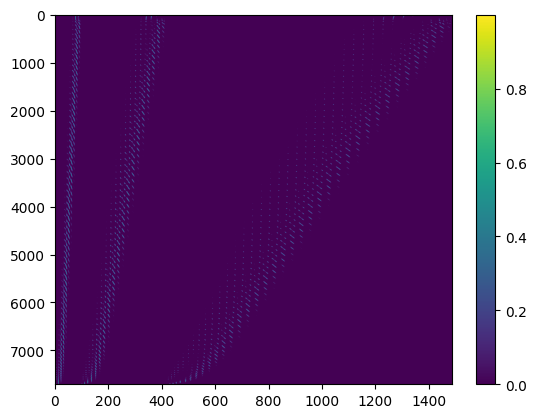

In [178]:
# phi_reduce 시각화
plt.imshow(phi_reduce, aspect='auto')
plt.colorbar()
plt.show()


In [179]:
# Recall) idx_new는 자료 병합 후 기상학 관측소의 인덱스를 의미합니다.
phi_obs = phi_reduce[idx_new,:]
s_obs = np.vstack((normalized_lon[idx_new], normalized_lat[idx_new])).T
X = covariates[idx_new,:]
    # phi_obs : 학습에 사용될 기상학 관측소의 basis function 값 행렬
    # s_obs : 학습에 사용될 기상학 관측소의 좌표
    # X : 학습에 사용될 기상학 관측소의 공변량

# 딥러닝을 위해 입력변수를 정규화
normalized_X = X

for i in range(X.shape[1]):
    normalized_X[:,i] = (X[:,i]-min(X[:,i]))/(max(X[:,i])-min(X[:,i]))

# 학습에 사용되는 기상학 관측소의 개수(데이터의 개수)
N_obs = X.shape[0]

In [180]:
N_obs

605

In [181]:
s_obs

array([[0.98031088, 0.90626846],
       [0.98309348, 0.88976228],
       [0.97423795, 0.81472205],
       ...,
       [0.46866546, 0.09037756],
       [0.46017898, 0.03567999],
       [0.47059468, 0.03292622]])

## The risk of high pollution $\mathbb{I}(PM_{2.5} > 12 \, \mu g / m^3)$ class 나누기

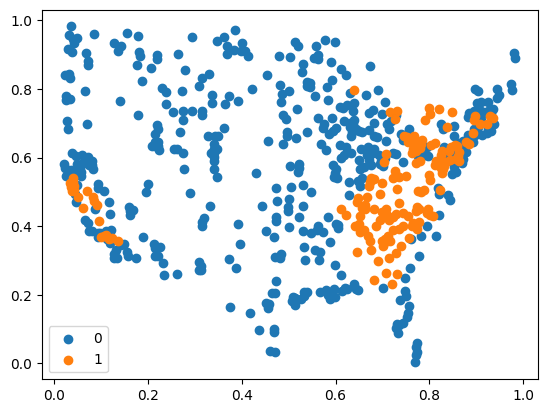

In [182]:
# scatter plot of the circles dataset with points colored by class
from numpy import where
from matplotlib import pyplot

# select indices of points with each class label
for i in range(2):
	samples_ix = where(z_class[:,0] == i)
	pyplot.scatter(s_obs[samples_ix, 0], s_obs[samples_ix, 1], label=str(i))
pyplot.legend()
pyplot.show()

In [183]:
## Save the prepocessed data for Kriging
z_log = np.log(z)
kriging = np.concatenate((s_obs, normalized_X, z, z_class, z_log), axis=1)
traindf=pd.DataFrame(kriging)
traindf.to_csv('C:\git\DeepKriging\kriging.csv')

 C:\Users\권헌정\AppData\Local\Temp\ipykernel_26784\4019827700.py:2: RuntimeWarning:divide by zero encountered in log


# 모형 성능 측정

## Load the useful functions

> 주의: deep_model 함수에 model.compile과 model.fit이 내장되어 있습니다.

In [184]:
def deep_model(model, X_train, y_train, X_valid, y_valid, data_type):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    if data_type == 'continuous':
        model.compile(optimizer='adam'
                      , loss='mse'
                      , metrics=['mse','mae'])
    if data_type == 'discrete':
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test, verbose=0)
    return results
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    return min_epoch

## Specify the model structure: Prediction

출력 레이어에 "ReLU" 활성함수를 사용하는것이 PM 데이터에는 자연스럽습니다.
따라서, DeepKriging 모형의 기본 출력 레이어를 "ReLU"로 설정하고, 일반적으로 사용하는 "linear"로 설정하였을때는 다음과 같은 변환을 통해 분석했습니다.

$$
\tilde{y} = log(1+y)
$$

즉, $\tilde{y}$를 이용하여 모형을 학습하고 예측값을 구하여 다시 역변환 하여 최종 예측값으로 사용할 것입니다. 이 모형을 "Log DeepKriging"이라고 부르겠습니다.

### DeepKriging

In [185]:
# DeepKriging model for continuous data
p = covariates.shape[1] + phi_reduce.shape[1]
model = Sequential()
model.add(Dense(100, input_dim = p, kernel_initializer='he_uniform', activation='relu'))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='relu'))

### Log DeepKriging

In [186]:
# DeepKriging model for continuous log transfomed data
p = covariates.shape[1] + phi_reduce.shape[1]
model_log = Sequential()
model_log.add(Dense(100, input_dim = p, kernel_initializer='he_uniform', activation='relu'))
model_log.add(Dropout(rate=0.5))
model_log.add(BatchNormalization())
model_log.add(Dense(100, activation='relu'))
model_log.add(Dropout(rate=0.5))
model_log.add(Dense(100, activation='relu'))
model_log.add(BatchNormalization())
model_log.add(Dense(1, activation='linear'))

### Deeper DeepKriging

In [187]:
# Deeper DeepKriging model for continuous data 
p = covariates.shape[1] + phi_reduce.shape[1]
model_deep = Sequential()
model_deep.add(Dense(100, input_dim = p, kernel_initializer='he_uniform', activation='relu'))
model_deep.add(Dropout(rate=0.5))
model_deep.add(BatchNormalization())
model_deep.add(Dense(100, activation='relu'))
model_deep.add(Dropout(rate=0.5))
model_deep.add(Dense(100, activation='relu'))
model_deep.add(BatchNormalization())
model_deep.add(Dense(100, activation='relu'))
model_deep.add(Dropout(rate=0.5))
model_deep.add(Dense(100, activation='relu'))
model_deep.add(BatchNormalization())
model_deep.add(Dense(1, activation='relu'))

### Baseline DNN

In [188]:
# Baseline DNN only with covariates and coordinates
p_base = covariates.shape[1] + s_obs.shape[1]
# Neural network
model_base = Sequential()
model_base.add(Dense(100, input_dim=p_base, kernel_initializer='he_uniform', activation='relu'))
model_base.add(Dropout(rate=0.5))
model_base.add(BatchNormalization())
model_base.add(Dense(100, activation='relu'))
model_base.add(Dropout(rate=0.5))
model_base.add(Dense(100, activation='relu'))
model_base.add(BatchNormalization())
model_base.add(Dense(1, activation='relu'))

## Specify the model structure: Classification

### DeepKriging for classification

In [189]:
# DeepKriging model for categorical data
model_class = Sequential()
model_class.add(Dense(100, input_dim = p,  kernel_initializer='he_uniform', activation='relu'))
model_class.add(Dropout(rate=0.5))
model_class.add(BatchNormalization())
model_class.add(Dense(100, activation='relu'))
model_class.add(Dropout(rate=0.5))
model_class.add(Dense(100, activation='relu'))
model_class.add(BatchNormalization())
model_class.add(Dense(1, activation='sigmoid'))

### Deeper Deepkriging for classification

In [190]:
# Deeper DeepKriging model for categorical data
model_class_deep = Sequential()
model_class_deep.add(Dense(100, input_dim = p,  kernel_initializer='he_uniform', activation='relu'))
model_class_deep.add(Dropout(rate=0.5))
model_class_deep.add(BatchNormalization())
model_class_deep.add(Dense(100, activation='relu'))
model_class_deep.add(Dropout(rate=0.5))
model_class_deep.add(Dense(100, activation='relu'))
model_class_deep.add(BatchNormalization())
model_class_deep.add(Dense(100, activation='relu'))
model_class_deep.add(Dropout(rate=0.5))
model_class_deep.add(Dense(100, activation='relu'))
model_class_deep.add(BatchNormalization())
model_class_deep.add(Dense(1, activation='sigmoid'))

### Baseline DNN for classification

In [191]:
# Baseline DNN for classification
model_base_class = Sequential()
model_base_class.add(Dense(100, input_dim=p_base,  kernel_initializer='he_uniform', activation='relu'))
model_base_class.add(Dropout(rate=0.5))
model_base_class.add(BatchNormalization())
model_base_class.add(Dense(100, activation='relu'))
model_base_class.add(Dropout(rate=0.5))
model_base_class.add(Dense(100, activation='relu'))
model_base_class.add(BatchNormalization())
model_base_class.add(Dense(1, activation='sigmoid'))

## CV(run cross-validation)

In [192]:
from sklearn.model_selection import KFold
NB_START_EPOCHS = 200  # Number of epochs we usually start to train with
BATCH_SIZE = 64  # Size of the batches used in the mini-batch gradient descent

In [193]:
#####################################################################################
########### 주의: 이 셀 실행시간 약 10분 소요(연구실 컴퓨터 기준) #######################
#####################################################################################

# fold cross-validation
num_folds = 5

kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 123)
    # KFold() : K-Folds cross-validator 생성
    # n_splits : 폴드 수
    # shuffle : 데이터를 분할하기 전 무작위로 섞을지 여부
    # random_state : 데이터를 무작위로 섞을 때 사용하는 난수 발생기 시드

inputs = np.hstack((normalized_X, phi_obs)) # DeepKriging을 위한 입력변수
inputs_base = np.hstack((normalized_X, s_obs)) # Baseline DNN을 위한 입력변수

targets = z
targets_log = np.log1p(z)
targets_class = z_class

# 성능 비교 값들 받을 리스트 생성
mse_per_fold = []
mse_per_fold_log = []
mse_per_fold_deep = []
mse_per_fold_base = []

mae_per_fold = []
mae_per_fold_log = []
mae_per_fold_deep = []
mae_per_fold_base = []

acc_per_fold = []
acc_per_fold_deep = []
acc_per_fold_base = []

# 폴드 번호 지정
fold_no = 1

for train_idx, test_idx in kfold.split(inputs, targets):
        # kfold.split() : 각 폴드에 대해 학습용, 테스트용 인덱스를 생성
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # DeepKriging과 Baseline DNN을 학습(train set을 이용)하고 출력물들(history)을 저장
    ## deep_model() 함수를 이용하여 위에서 정의한 medel들을 학습
    
    ### Continuous
    history = deep_model(model, inputs[train_idx], targets[train_idx,0:1]\
                              , inputs[test_idx], targets[test_idx,0:1],'continuous')
    history_log = deep_model(model_log, inputs[train_idx], targets_log[train_idx,0:1]\
                              , inputs[test_idx], targets_log[test_idx,0:1],'continuous')
    history_deep = deep_model(model_deep, inputs[train_idx], targets[train_idx,0:1]\
                              , inputs[test_idx], targets[test_idx,0:1],'continuous')                          
    history_base = deep_model(model_base, inputs_base[train_idx], targets[train_idx,0:1]\
                              , inputs_base[test_idx], targets[test_idx,0:1],'continuous')
    
    ### Classification
    history_class = deep_model(model_class, inputs[train_idx], targets_class[train_idx,0:1]\
                              , inputs[test_idx], targets_class[test_idx,0:1],'discrete')
    history_deep_class = deep_model(model_class_deep, inputs[train_idx], targets_class[train_idx,0:1]\
                                , inputs[test_idx], targets_class[test_idx,0:1],'discrete')                          
    history_base_class = deep_model(model_base_class, inputs_base[train_idx], targets_class[train_idx,0:1]\
                              , inputs_base[test_idx], targets_class[test_idx,0:1],'discrete')

    
    # 위의 학습에서 얻은 history를 통해 최적의 epoch를 찾음
    ## 여기서 최적의 epoch는 validation loss가 최소가 되는 epoch를 의미
    model_optim = optimal_epoch(history)    
    model_optim_log = optimal_epoch(history_log) 
    model_optim_deep = optimal_epoch(history_deep) 
    model_optim_base = optimal_epoch(history_base) 

    # 모형들의 예측결과를 저장(test set을 이용)
    ## train set으로 모델을 학습하고 이를 통해 얻은 모델 파라미터로 test set을 예측
    ## 그 결과인 MSE, MAE를 저장
    result = test_model(model, inputs[train_idx], targets[train_idx,0:1], inputs[test_idx]\
                        , targets[test_idx,0:1], model_optim)
    result_log = test_model(model, inputs[train_idx], targets_log[train_idx,0:1], inputs[test_idx]\
                        , targets_log[test_idx,0:1], model_optim_log)
    result_deep = test_model(model, inputs[train_idx], targets[train_idx,0:1], inputs[test_idx]\
                        , targets[test_idx,0:1], model_optim_deep)
    result_base = test_model(model_base, inputs_base[train_idx], targets[train_idx,0:1], inputs_base[test_idx]\
                             , targets[test_idx,0:1], model_optim_base)

    scores = result
    scores_log = result_log
    scores_deep = result_deep
    scores_base = result_base  
    
    print(f'DeepKriging: MSE = {scores[1]}, MAE = {scores[2]}')
    print(f'Log DeepKriging: MSE = {scores_log[1]}, MAE = {scores_log[2]}')
    print(f'Deeper DeepKriging: MSE = {scores_deep[1]}, MAE = {scores_deep[2]}')
    print(f'Baseline DNN: MSE = {scores_base[1]}, MAE = {scores_base[2]}')
    # 위에까지 Continuous 경우의 Metric을 출력
    
    model_optim_class = optimal_epoch(history_class) 
    model_optim_deep_class = optimal_epoch(history_deep_class)
    model_optim_base_class = optimal_epoch(history_base_class) 

    result_class = test_model(model_class, inputs[train_idx], targets_class[train_idx,0:1], inputs[test_idx]\
                        , targets_class[test_idx,0:1], model_optim_class)
    result_deep_class = test_model(model_class_deep, inputs[train_idx], targets_class[train_idx,0:1], inputs[test_idx]\
                        , targets_class[test_idx,0:1], model_optim_deep_class)
    result_base_class = test_model(model_base_class, inputs_base[train_idx], targets_class[train_idx,0:1], inputs_base[test_idx]\
                             , targets_class[test_idx,0:1], model_optim_base_class)

    scores_class = result_class
    scores_deep_class = result_deep_class
    scores_base_class = result_base_class

    print(f'DeepKriging: accuracy = {scores_class[1]}')
    print(f'Deeper DeepKriging: accuracy = {scores_deep_class[1]}')
    print(f'Baseline DNN: accuracy = {result_base_class[1]}')
    # 여기까지는 Classification 경우의 Metric을 출력

    fold_no = fold_no + 1 # fold_no 증가

    # 결과값들을 리스트에 저장
    acc_per_fold.append(scores_class[1])
    acc_per_fold_deep.append(scores_deep_class[1])
    acc_per_fold_base.append(scores_base_class[1])

    mse_per_fold.append(scores[1])
    mse_per_fold_log.append(scores_log[1])
    mse_per_fold_deep.append(scores_deep[1])
    mse_per_fold_base.append(scores_base[1])

    mae_per_fold.append(scores[2])
    mae_per_fold_log.append(scores_log[2])
    mae_per_fold_deep.append(scores_deep[2])
    mae_per_fold_base.append(scores_base[2])



------------------------------------------------------------------------
Training for fold 1 ...
DeepKriging: MSE = 5.833099842071533, MAE = 1.8044883012771606
Log DeepKriging: MSE = 0.061541613191366196, MAE = 0.18698522448539734
Deeper DeepKriging: MSE = 6.5272369384765625, MAE = 1.9079657793045044
Baseline DNN: MSE = 6.483357906341553, MAE = 1.8840157985687256
DeepKriging: accuracy = 0.8677685856819153
Deeper DeepKriging: accuracy = 0.8842975497245789
Baseline DNN: accuracy = 0.9008264541625977
------------------------------------------------------------------------
Training for fold 2 ...
DeepKriging: MSE = 5.599028587341309, MAE = 1.7482064962387085
Log DeepKriging: MSE = 0.383312851190567, MAE = 0.5281050801277161
Deeper DeepKriging: MSE = 5.950469493865967, MAE = 1.7748347520828247
Baseline DNN: MSE = 5.069364547729492, MAE = 1.6750130653381348
DeepKriging: accuracy = 0.9090909361839294
Deeper DeepKriging: accuracy = 0.9090909361839294
Baseline DNN: accuracy = 0.8429751992225647

In [194]:
## MSE와 MAE의 평균값을 계산
print('------------------------------------------------------------------------')
print('Score per fold')
print('------------------------------------------------------------------------')
print('Average scores for DeepKriging:')
print(f'> MSE: {np.mean(mse_per_fold)}')
print(f'> MAE: {np.mean(mae_per_fold)}')
print('------------------------------------------------------------------------')
print('Average scores for Log DeepKriging:')
print(f'> MSE: {np.mean(mse_per_fold_log)}')
print(f'> MAE: {np.mean(mae_per_fold_log)}')
print('------------------------------------------------------------------------')
print('Average scores for DeepKriging with the deeper hidden layers:')
print(f'> MSE: {np.mean(mse_per_fold_deep)}')
print(f'> MAE: {np.mean(mae_per_fold_deep)}')
print('------------------------------------------------------------------------')
print('Average scores for Baseline DNN:')
print(f'> MSE: {np.mean(mse_per_fold_base)}')
print(f'> MAE: {np.mean(mae_per_fold_base)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
Average scores for DeepKriging:
> MSE: 4.439042282104492
> MAE: 1.5605557680130004
------------------------------------------------------------------------
Average scores for Log DeepKriging:
> MSE: 6.376342683285475
> MAE: 1.6209293067455293
------------------------------------------------------------------------
Average scores for DeepKriging with the deeper hidden layers:
> MSE: 10.687757110595703
> MAE: 2.2999993801116942
------------------------------------------------------------------------
Average scores for Baseline DNN:
> MSE: 5.132987594604492
> MAE: 1.6960548162460327
------------------------------------------------------------------------


In [195]:
#  평균의 표준편차도 출력
print('------------------------------------------------------------------------')
print('Standard deviation per fold')
print('------------------------------------------------------------------------')
print('Standard deviation for DeepKriging:')
print(f'> MSE: {np.std(mse_per_fold)}')
print(f'> MAE: {np.std(mae_per_fold)}')
print('------------------------------------------------------------------------')
print('Standard deviation for Log DeepKriging:')
print(f'> MSE: {np.std(mse_per_fold_log)}')
print(f'> MAE: {np.std(mae_per_fold_log)}')
print('------------------------------------------------------------------------')
print('Standard deviation for DeepKriging with the deeper hidden layers:')
print(f'> MSE: {np.std(mse_per_fold_deep)}')
print(f'> MAE: {np.std(mae_per_fold_deep)}')
print('------------------------------------------------------------------------')
print('Standard deviation for Baseline DNN:')
print(f'> MSE: {np.std(mse_per_fold_base)}')
print(f'> MAE: {np.std(mae_per_fold_base)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Standard deviation per fold
------------------------------------------------------------------------
Standard deviation for DeepKriging:
> MSE: 1.0955181452636258
> MAE: 0.1852536245073735
------------------------------------------------------------------------
Standard deviation for Log DeepKriging:
> MSE: 10.245833063053471
> MAE: 1.7349149242628559
------------------------------------------------------------------------
Standard deviation for DeepKriging with the deeper hidden layers:
> MSE: 12.018323598029662
> MAE: 1.4198007893371598
------------------------------------------------------------------------
Standard deviation for Baseline DNN:
> MSE: 0.9410868426821711
> MAE: 0.14121817358538594
------------------------------------------------------------------------


In [196]:
# Accuracy의 평균값을 계산
print('------------------------------------------------------------------------')
print('Score per fold')
print('------------------------------------------------------------------------')
print('Average scores for DeepKriging:')
print(f'> Accuracy: {np.mean(acc_per_fold)}')
print('------------------------------------------------------------------------')
print('Average scores for DeepKriging with the deeper hidden layers:')
print(f'> Accuracy: {np.mean(acc_per_fold_deep)}')
print('------------------------------------------------------------------------')
print('Average scores for Baseline DNN:')
print(f'> Accuracy: {np.mean(acc_per_fold_base)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
Average scores for DeepKriging:
> Accuracy: 0.915702486038208
------------------------------------------------------------------------
Average scores for DeepKriging with the deeper hidden layers:
> Accuracy: 0.9107438206672669
------------------------------------------------------------------------
Average scores for Baseline DNN:
> Accuracy: 0.8892562031745911
------------------------------------------------------------------------


In [197]:
# Accuracy의 표준편차도 출력
print('------------------------------------------------------------------------')
print('Standard deviation per fold')
print('------------------------------------------------------------------------')
print('Standard deviation for DeepKriging:')
print(f'> Accuracy: {np.std(acc_per_fold)}')
print('------------------------------------------------------------------------')
print('Standard deviation for DeepKriging with the deeper hidden layers:')
print(f'> Accuracy: {np.std(acc_per_fold_deep)}')
print('------------------------------------------------------------------------')
print('Standard deviation for Baseline DNN:')
print(f'> Accuracy: {np.std(acc_per_fold_base)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Standard deviation per fold
------------------------------------------------------------------------
Standard deviation for DeepKriging:
> Accuracy: 0.02634277553851056
------------------------------------------------------------------------
Standard deviation for DeepKriging with the deeper hidden layers:
> Accuracy: 0.024179721373400766
------------------------------------------------------------------------
Standard deviation for Baseline DNN:
> Accuracy: 0.02539221739963513
------------------------------------------------------------------------


위의 로그변환과 더 깊은 모형의 CV과정을 살펴보면 값들이 확확 튀는 것을 볼 수 있습니다. 아마도, 데이터를 trian set와 test set으로 split할때, 공간적인 상관성을 고려하지 않아서 과적합 문제가 발생한것으로 생각할 수 있을것 같습니다.

In [198]:
## Save the same test index for Kriging: 저자는 R로 크리깅을 수행한것으로 보입니다.
train_idx_combine = []
test_idx_combine = []
for train_idx, test_idx in kfold.split(inputs, targets):
    train_idx_combine.append(train_idx)
    test_idx_combine.append(test_idx)  
test_df = pd.DataFrame(test_idx_combine).T
test_df.to_csv('C:\git\DeepKriging/test_idx.csv')

## The case without covariates: Embeding Layer만 사용

In [199]:
# DeepKriging model for continuous data
p2 =  phi_reduce.shape[1] # Embedding layer만 사용
model_nx = Sequential()
model_nx.add(Dense(100, input_dim = p2,  kernel_initializer='he_uniform', activation='relu'))
model_nx.add(Dropout(rate=0.5))
model_nx.add(BatchNormalization())
model_nx.add(Dense(100, activation='relu'))
model_nx.add(Dropout(rate=0.5))
model_nx.add(Dense(100, activation='relu'))
model_nx.add(BatchNormalization())
model_nx.add(Dense(1, activation='relu'))

In [200]:
# DeepKriging model for categorical data
model_class_nx = Sequential()
model_class_nx.add(Dense(100, input_dim = p2,  kernel_initializer='he_uniform', activation='relu'))
model_class_nx.add(Dropout(rate=0.5))
model_class_nx.add(BatchNormalization())
model_class_nx.add(Dense(100, activation='relu'))
model_class_nx.add(Dropout(rate=0.5))
model_class_nx.add(Dense(100, activation='relu'))
model_class_nx.add(BatchNormalization())
model_class_nx.add(Dense(1, activation='sigmoid'))

In [201]:
inputs = phi_obs
# inputs_base = s_obs

targets = z
targets_class = z_class

mse_per_fold_nx = []
mae_per_fold_nx = []
acc_per_fold_nx = []

fold_no = 1

for train_idx, test_idx in kfold.split(inputs, targets):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history_nx = deep_model(model_nx, inputs[train_idx], targets[train_idx,0:1]\
                              , inputs[test_idx], targets[test_idx,0:1],'continuous')
    ## Classification
    history_class_nx = deep_model(model_class_nx, inputs[train_idx], targets_class[train_idx,0:1]\
                              , inputs[test_idx], targets_class[test_idx,0:1],'discrete')
    model_optim_nx = optimal_epoch(history_nx)
    result_nx = test_model(model_nx, inputs[train_idx], targets[train_idx,0:1], inputs[test_idx]\
                        , targets[test_idx,0:1], model_optim_nx)
    scores_nx = result_nx
    print(f'The performance of DeepKriging without X: MSE = {scores_nx[1]}, MAE = {scores_nx[2]}')
    model_optim_class_nx = optimal_epoch(history_class_nx)
    result_class_nx = test_model(model_class_nx, inputs[train_idx], targets_class[train_idx,0:1], inputs[test_idx]\
                        , targets_class[test_idx,0:1], model_optim_class_nx)
    scores_class_nx = result_class_nx
    print(f'The performance of DeepKriging without X: accuracy = {scores_class_nx[1]}')
    fold_no = fold_no + 1
    acc_per_fold_nx.append(scores_class_nx[1])
    mse_per_fold_nx.append(scores_nx[1])
    mae_per_fold_nx.append(scores_nx[2])

------------------------------------------------------------------------
Training for fold 1 ...
The performance of DeepKriging without X: MSE = 6.066629886627197, MAE = 1.8267186880111694
The performance of DeepKriging without X: accuracy = 0.8842975497245789
------------------------------------------------------------------------
Training for fold 2 ...
The performance of DeepKriging without X: MSE = 5.8742876052856445, MAE = 1.7939307689666748
The performance of DeepKriging without X: accuracy = 0.9173553586006165
------------------------------------------------------------------------
Training for fold 3 ...
The performance of DeepKriging without X: MSE = 5.204687118530273, MAE = 1.7624717950820923
The performance of DeepKriging without X: accuracy = 0.93388432264328
------------------------------------------------------------------------
Training for fold 4 ...
The performance of DeepKriging without X: MSE = 3.1697661876678467, MAE = 1.3205814361572266
The performance of DeepKrigi

In [202]:
# 평균값 계산
print('------------------------------------------------------------------------')
print('Score per fold')
print('------------------------------------------------------------------------')
print('Average scores for DeepKriging without X:')
print(f'> MSE: {np.mean(mse_per_fold_nx)}')
print(f'> MAE: {np.mean(mae_per_fold_nx)}')
print('------------------------------------------------------------------------')
print('Average scores for DeepKriging without X:')
print(f'> Accuracy: {np.mean(acc_per_fold_nx)}')
print('------------------------------------------------------------------------')

# 표준편차 계산
print('------------------------------------------------------------------------')
print('Standard deviation per fold')
print('------------------------------------------------------------------------')
print('Standard deviation for DeepKriging without X:')
print(f'> MSE: {np.std(mse_per_fold_nx)}')
print(f'> MAE: {np.std(mae_per_fold_nx)}')
print('------------------------------------------------------------------------')
print('Standard deviation for DeepKriging without X:')
print(f'> Accuracy: {np.std(acc_per_fold_nx)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
Average scores for DeepKriging without X:
> MSE: 4.612682104110718
> MAE: 1.5784369230270385
------------------------------------------------------------------------
Average scores for DeepKriging without X:
> Accuracy: 0.9256198525428772
------------------------------------------------------------------------
------------------------------------------------------------------------
Standard deviation per fold
------------------------------------------------------------------------
Standard deviation for DeepKriging without X:
> MSE: 1.386721319185246
> MAE: 0.2685161513552046
------------------------------------------------------------------------
Standard deviation for DeepKriging without X:
> Accuracy: 0.024516359365676418
------------------------------------------------------------------------


# Prediction

앞에서 구성한 모형들을 이용하여, 미관측 기상학 자료 관측소에 대한 $PM_{2.5}$ 농도에 대한 예측을 진행한다. 먼저, 모형의 학습과 예측을 위해 변수들을 정리한다.

In [203]:
# DeepKriging fitting을 위한 입력변수 정규화
inputs = np.hstack((normalized_X, phi_obs)) 
    # 매칭 후 기상학 데이터와 이를 기반으로한 embedding layer를 입력변수로 지정

inputs_base = np.hstack((normalized_X, s_obs)) 
    # 매칭 후 기상학 데이터와 좌표를 입력변수로 지정

s_norm = np.vstack((normalized_lon, normalized_lat)).T

# DeepKriging Prediction을 위한 입력변수 정규화
X_pred = covariates

normalized_X_pred = X_pred

for i in range(X_pred.shape[1]):
    normalized_X_pred[:,i] = (X_pred[:,i]-min(X_pred[:,i]))/(max(X_pred[:,i])-min(X_pred[:,i]))

## Recall phi_reduce는 zero column을 제거한 전체 데이터의 basis function 값 
X_RBF_pred = np.hstack((normalized_X_pred, phi_reduce))

inputs_base_pred = np.hstack((normalized_X_pred, s_norm))

# 설명변수 설정
targets = z
targets_class = z_class
log_targets = np.log1p(z)


## Deep Kriging

In [204]:
# DeepKriging model 적합: 배치 사이즈와 에포크는 기본값으로 수행
history_p = deep_model(model, inputs, targets[:,0:1], inputs, targets[:,0:1],'continuous')

# DeepKriging의 예측값 계산
PM25_pred = model.predict(X_RBF_pred, batch_size=BATCH_SIZE)
    # 매칭 전 모든 기상데이터 관측점에 대한 PM2.5 예측값 계산

121/121 [==============================] - 0s 1ms/step


## Log DeepKriging

In [205]:
history_p_log = deep_model(model_log, inputs, log_targets[:,0:1], inputs, log_targets[:,0:1],'continuous')

PM25_pred_log = model_log.predict(X_RBF_pred, batch_size=BATCH_SIZE)

121/121 [==============================] - 0s 1ms/step


## Deeper DeepKriging

In [206]:
history_p_deep = deep_model(model_deep, inputs, targets[:,0:1], inputs, targets[:,0:1],'continuous')

PM25_pred_deep = model_deep.predict(X_RBF_pred, batch_size=BATCH_SIZE)

121/121 [==============================] - 0s 1ms/step


## Baseline DNN

In [207]:
history_p_base = deep_model(model_base, inputs_base, targets[:,0:1], inputs_base, targets[:,0:1],'continuous')

PM25_pred_base = model_base.predict(inputs_base_pred, batch_size=BATCH_SIZE)

121/121 [==============================] - 0s 648us/step


## Baseline DNN NO X

In [208]:
history_p_nx = deep_model(model_nx, phi_obs, targets[:,0:1], phi_obs, targets[:,0:1],'continuous')

PM25_pred_nx = model_nx.predict(phi_reduce, batch_size=BATCH_SIZE)

121/121 [==============================] - 0s 1ms/step


# Classification

## DeepKriging

In [209]:
history_p_class = deep_model(model_class, inputs, targets_class[:,0:1], inputs, targets_class[:,0:1],'discrete')

PM25_pred_class = model_class.predict(X_RBF_pred, batch_size=BATCH_SIZE)

121/121 [==============================] - 0s 1ms/step


## Deeper DeepKriging

In [210]:
history_p_deep_class = deep_model(model_class_deep, inputs, targets_class[:,0:1], inputs, targets_class[:,0:1],'discrete')

PM25_pred_deep_class = model_class_deep.predict(X_RBF_pred, batch_size=BATCH_SIZE)

121/121 [==============================] - 0s 2ms/step


## Baseline DNN

In [212]:
history_p_base_class = deep_model(model_base_class, inputs_base, targets_class[:,0:1], inputs_base, targets_class[:,0:1],'discrete')

PM25_pred_base_class = model_base_class.predict(inputs_base_pred, batch_size=BATCH_SIZE)

121/121 [==============================] - 0s 638us/step


## Baseline DNN NO X

In [213]:
history_p_nx_class = deep_model(model_class_nx, phi_obs, targets_class[:,0:1], phi_obs, targets_class[:,0:1],'discrete')

PM25_pred_nx_class = model_class_nx.predict(phi_reduce, batch_size=BATCH_SIZE)

121/121 [==============================] - 0s 2ms/step


# Store the predicted values

In [214]:
s = np.vstack((lon, lat)).T

## 예측값 저장
PM25_pred_combine = np.concatenate((s, normalized_X_pred, PM25_pred), axis=1) # DeepKriging 예측값 저장

PM25_pred_log_back = np.exp(PM25_pred_log)-1 # DeepKriging 예측값 역변환
PM25_pred_log_combine = np.concatenate((s, normalized_X_pred, PM25_pred_log_back), axis=1) # 수정된 DeepKriging 예측값 저장: 재변환

PM25_pred_deep_combine = np.concatenate((s, normalized_X_pred, PM25_pred_deep), axis=1) # DeepKriging with deeper hidden layers 예측값 저장

PM25_pred_base_combine = np.concatenate((s, normalized_X_pred, PM25_pred_base), axis=1) # Baseline DNN 예측값 저장

PM25_pred_nx_combine = np.concatenate((s, PM25_pred_nx), axis=1) # DeepKriging without X 예측값 저장

## Calssification 예측값 저장
PM25_pred_class_combine = np.concatenate((s, normalized_X_pred, PM25_pred_class), axis=1) # DeepKriging class 예측값 저장

PM25_pred_deep_class_combine = np.concatenate((s, normalized_X_pred, PM25_pred_deep_class), axis=1) # DeepKriging with deeper hidden layers class 예측값 저장

PM25_pred_base_class_combine = np.concatenate((s, normalized_X_pred, PM25_pred_base_class), axis=1) # Baseline DNN class 예측값 저장

PM25_pred_nx_class_combine = np.concatenate((s, PM25_pred_nx_class), axis=1) # DeepKriging without X class 예측값 저장


In [215]:
# DeepKriging 외부로 저장: 입력변수 및 좌표 정규화
s_norm = np.vstack((normalized_lon, normalized_lat)).T

PM25_pred_combine_norm = np.concatenate((s_norm, normalized_X_pred, PM25_pred), axis=1)

PM25_pred_df=pd.DataFrame(PM25_pred_combine_norm)
PM25_pred_df.to_csv('C:\git\DeepKriging\PM25_pred_0605.csv')

# 예측값 시각화

In [216]:
df2.head(1)

,Unnamed: 0,Longitude,Latitude,PM25,PM_class
0,1,-80.482778,25.471944,4.4,1


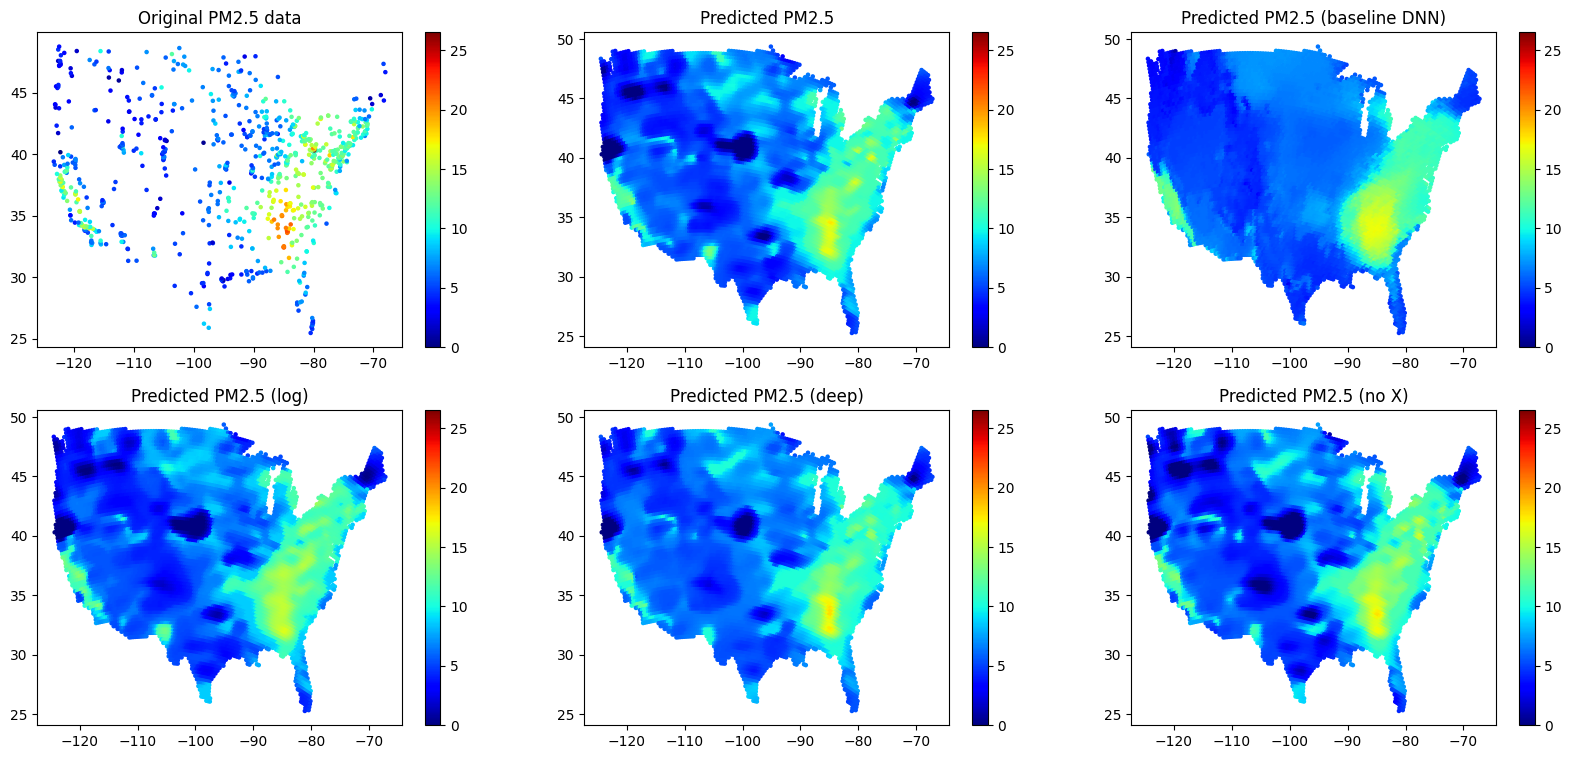

In [223]:
# 관측값과 예측값의 최소값과 최대값을 계산
vmin = 0
vmax = max(df2['PM25'].max(), PM25_pred.max(), PM25_pred_log_back.max(), PM25_pred_deep.max(), PM25_pred_base.max(), PM25_pred_nx.max())
cmap = 'jet'
s=5

fig, axs = plt.subplots(2, 3, figsize=(20,9))

# 원자료 시각화
sc1 = axs[0, 0].scatter(df2.values[:,1], df2.values[:,2], c=df2.values[:,3], s=s, cmap=cmap, vmin=vmin, vmax=vmax ) 
axs[0, 0].set_title('Original PM2.5 data')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('')
fig.colorbar(sc1, ax=axs[0, 0])

# PM2.5 예측값 시각화
sc2 = axs[0, 1].scatter(PM25_pred_combine[:,0], PM25_pred_combine[:,1], c=PM25_pred_combine[:,8], s=s, cmap=cmap, vmin=vmin, vmax=vmax) 
axs[0, 1].set_title('Predicted PM2.5')
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('')
fig.colorbar(sc2, ax=axs[0, 1])

# 로그변환 시각화
sc3 = axs[1, 0].scatter(PM25_pred_log_combine[:,0], PM25_pred_log_combine[:,1], c=PM25_pred_log_combine[:,8], s=s, cmap=cmap, vmin=vmin, vmax=vmax) 
axs[1, 0].set_title('Predicted PM2.5 (log)')
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('')
fig.colorbar(sc3, ax=axs[1, 0])
    
# 더 깊은 모형 시각화
sc4 = axs[1, 1].scatter(PM25_pred_deep_combine[:,0], PM25_pred_deep_combine[:,1], c=PM25_pred_deep_combine[:,8], s=s, cmap=cmap, vmin=vmin, vmax=vmax) 
axs[1, 1].set_title('Predicted PM2.5 (deep)')
axs[1, 1].set_xlabel('')
axs[1, 1].set_ylabel('')
fig.colorbar(sc4, ax=axs[1, 1])

# Baseline DNN 시각화
sc5 = axs[0, 2].scatter(PM25_pred_base_combine[:,0], PM25_pred_base_combine[:,1], c=PM25_pred_base_combine[:,8], s=s, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0, 2].set_title('Predicted PM2.5 (baseline DNN)')
axs[0, 2].set_xlabel('')
axs[0, 2].set_ylabel('')
fig.colorbar(sc5, ax=axs[0, 2])

# Baseline DNN No X 시각화
sc6 = axs[1, 2].scatter(PM25_pred_nx_combine[:,0], PM25_pred_nx_combine[:,1], c=PM25_pred_nx_combine[:,2], s=s, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1, 2].set_title('Predicted PM2.5 (no X)')
axs[1, 2].set_xlabel('')
axs[1, 2].set_ylabel('')
fig.colorbar(sc6, ax=axs[1, 2])

plt.show()


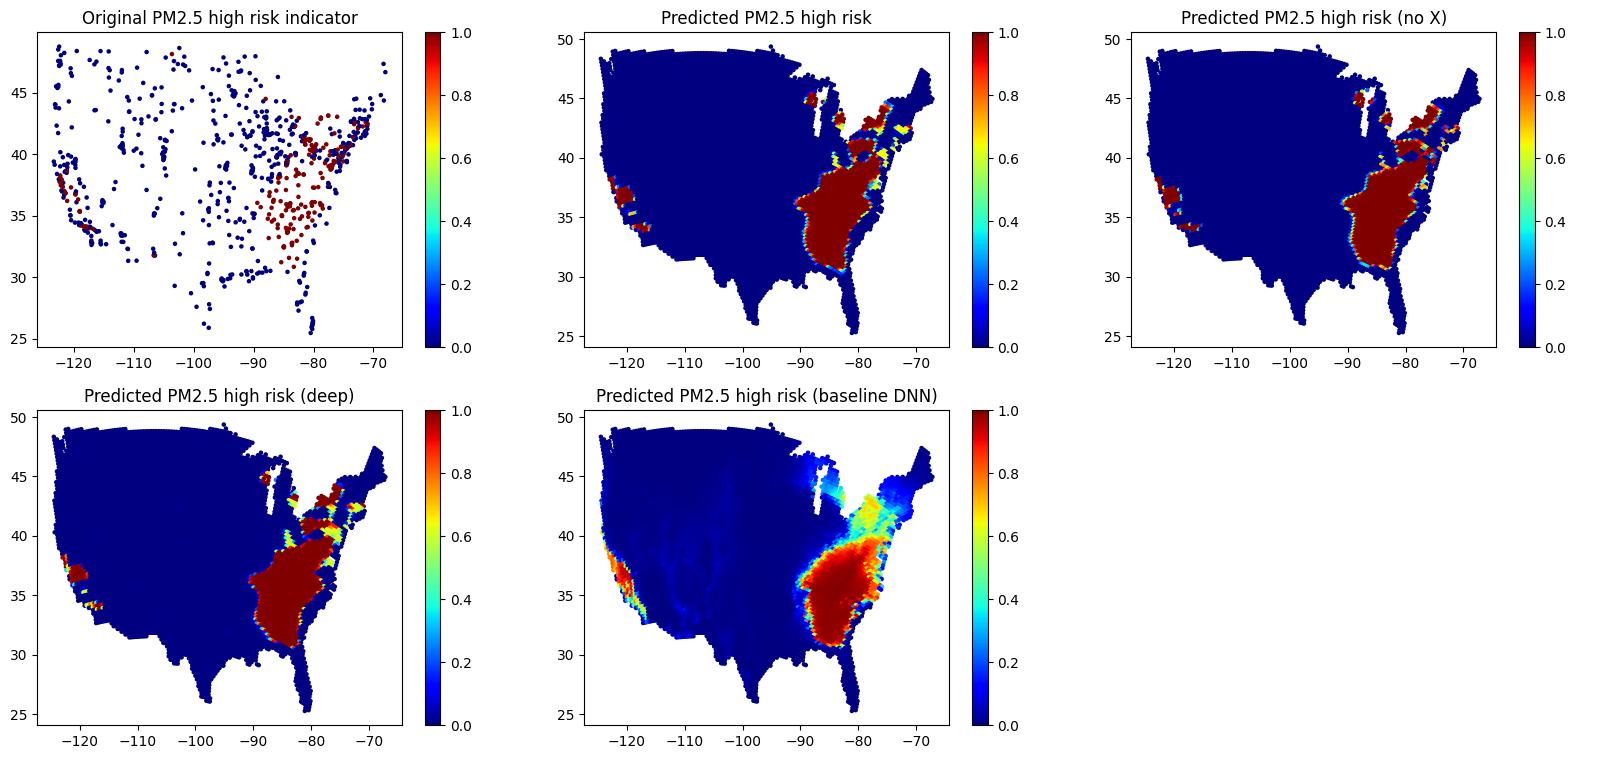

In [225]:
# Classification 결과 시각화

fig, axs = plt.subplots(2, 3, figsize=(20,9))

# PM2.5 class 관측값 시각화
scp1 = axs[0, 0].scatter(df2.values[:,1], df2.values[:,2], c=df2.values[:,4]-1, s=s, cmap=cmap, vmin=0, vmax=1)
        # c=df2.values[:,4]-1를 해준 이유는 PM2.5 class가 1부터 시작하기 때문에 1을 빼줌
axs[0, 0].set_title('Original PM2.5 high risk indicator')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('')
fig.colorbar(scp1, ax=axs[0, 0])

# high PM2.5 risk 예측값 시각화
scp2 = axs[0, 1].scatter(PM25_pred_class_combine[:,0], PM25_pred_class_combine[:,1], c=PM25_pred_class_combine[:,8], s=s,cmap=cmap, vmin=0, vmax=1)
axs[0, 1].set_title('Predicted PM2.5 high risk')
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('')
fig.colorbar(scp2, ax=axs[0, 1])

# DeepKriging with deeper hidden layers class 예측값 시각화
scp3 = axs[1, 0].scatter(PM25_pred_deep_class_combine[:,0], PM25_pred_deep_class_combine[:,1], c=PM25_pred_deep_class_combine[:,8], s=s, cmap=cmap, vmin=0, vmax=1)
axs[1, 0].set_title('Predicted PM2.5 high risk (deep)')
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('')
fig.colorbar(scp3, ax=axs[1, 0])

# Baseline DNN class 예측값 시각화
scp4 = axs[1, 1].scatter(PM25_pred_base_class_combine[:,0], PM25_pred_base_class_combine[:,1], c=PM25_pred_base_class_combine[:,8], s=s, cmap=cmap, vmin=0, vmax=1)
axs[1, 1].set_title('Predicted PM2.5 high risk (baseline DNN)')
axs[1, 1].set_xlabel('')
axs[1, 1].set_ylabel('')
fig.colorbar(scp4, ax=axs[1, 1])

# Baseline DNN No X class 예측값 시각화
scp5 = axs[0, 2].scatter(PM25_pred_nx_class_combine[:,0], PM25_pred_nx_class_combine[:,1], c=PM25_pred_nx_class_combine[:,2], s=s, cmap=cmap, vmin=0, vmax=1)
axs[0, 2].set_title('Predicted PM2.5 high risk (no X)')
axs[0, 2].set_xlabel('')
axs[0, 2].set_ylabel('')
fig.colorbar(scp5, ax=axs[0, 2])

axs[1, 2].axis('off')

plt.show()


### Risk

In [ ]:
# import sys
# sys.path.append('../')
# from dcdr.deep_hist import Binning_CDF
# from scipy.stats import iqr
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
# import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
# init_seed=1
# num_cut = int((max(z)-min(z))*N**(1/3)/(2*iqr(z)))
# hidden_list = [100,100,100]
# dropout_list = [0.5,0.5,0.5]
# histogram_bin = 'random'
# loss_model = 'multi-binary'
# seeding = 1

In [ ]:
# import tensorflow as tf

# # GPU 설정
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # 첫 번째 GPU만 사용하도록 설정
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        
#         # GPU 메모리 할당을 동적으로 조정
#         tf.config.experimental.set_memory_growth(gpus[0], True)
#     except RuntimeError as e:
#         print(e)

In [ ]:
# dcdr_model = Binning_CDF(num_cut=num_cut, hidden_list=hidden_list,
#                          histogram_bin=histogram_bin, dropout_list=dropout_list,
#                          seeding=seeding, loss_model=loss_model, 
#                          niter=10)
    
# dcdr_model.fit_cdf(inputs, targets, batch_size=32, merge_empty_bin=True)

In [ ]:
# risk = dcdr_model.predict_cdf(X_RBF_pred,pred_lim=[12,12],ngrid=1)

In [ ]:
# riskdf=pd.DataFrame(risk)
# riskdf.to_csv('C:\git\DeepKriging/risk_pred.csv')